### Script ARIMA model

#### Import libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

#### Load the data

In [2]:
data = pd.read_csv('/Users/nicolasdemuynck/BeCode/GNT-ARAI-1.25/Content/00.Use cases/arinti/20200124_ews_observations.csv',
                   low_memory=False)

#### Data preprocessing

In [3]:
data.dropna(inplace=True)

In [4]:
data['ObservationDate'] =  pd.to_datetime(data['ObservationDate']) #make datetime object
data.dtypes

PatientId                   int64
ObservationDate    datetime64[ns]
EwsProcedure               object
EWS_Total                   int64
SBP                       float64
SBP_Score                 float64
LOC                        object
LOC_Score                   int64
SpO2                      float64
SpO2_Score                float64
Add_O2                     object
Add_O2_Score              float64
HR                          int64
HR_Score                    int64
RR                          int64
RR_Score                    int64
TEMP                      float64
TEMP_Score                  int64
dtype: object

In [5]:
print(data.LOC.unique())

['ALERT' 'NEW_CONFUSION' 'VOICE' 'PAIN' 'UNRESPONSIVE']


In [6]:
encoder = LabelEncoder ()

for i in data.columns:
    if data[i].dtype == object:
        data[i] = encoder.fit_transform(data[i])
print(data.LOC.unique())

[0 1 4 2 3]


In [7]:
df = data[['ObservationDate','PatientId', 'EWS_Total', 'SBP', 'LOC', 'SpO2', 'HR', 'RR','TEMP']]
df.head(5)

,ObservationDate,PatientId,EWS_Total,SBP,LOC,SpO2,HR,RR,TEMP
0,2019-05-01 13:27:50,29,0,143.0,0,96.0,80,18,36.6
2,2019-05-01 15:54:27,31,1,117.0,0,95.0,75,14,37.3
4,2019-05-01 17:03:16,33,0,135.0,0,97.0,89,14,36.1
8,2019-05-01 21:08:05,32,0,125.0,0,97.0,87,14,37.1
10,2019-05-01 21:13:21,34,1,117.0,0,95.0,64,13,36.6


In [8]:
df.set_index('ObservationDate', inplace = True)
df.head(5)

,PatientId,EWS_Total,SBP,LOC,SpO2,HR,RR,TEMP
ObservationDate,,,,,,,,
2019-05-01 13:27:50,29,0,143.0,0,96.0,80,18,36.6
2019-05-01 15:54:27,31,1,117.0,0,95.0,75,14,37.3
2019-05-01 17:03:16,33,0,135.0,0,97.0,89,14,36.1
2019-05-01 21:08:05,32,0,125.0,0,97.0,87,14,37.1
2019-05-01 21:13:21,34,1,117.0,0,95.0,64,13,36.6


In [9]:
df.shape

(160947, 8)

In [10]:
patient = df.loc[(df['PatientId'] == 1743)]
patient.head(5)

,PatientId,EWS_Total,SBP,LOC,SpO2,HR,RR,TEMP
ObservationDate,,,,,,,,
2019-06-15 13:32:39,1743,4,122.0,0,91.0,112,18,36.6
2019-06-15 20:22:36,1743,5,109.0,0,93.0,104,16,37.0
2019-06-16 14:23:34,1743,3,117.0,0,89.0,103,19,36.5
2019-06-16 19:49:24,1743,3,123.0,0,90.0,107,19,36.6
2019-06-17 04:39:15,1743,4,102.0,0,92.0,97,18,36.7


In [11]:
patient.shape

(616, 8)

#### Manual plots

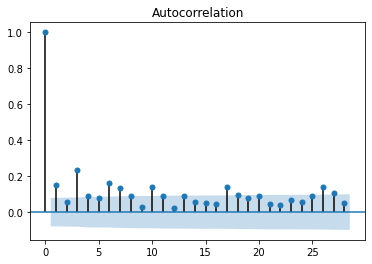

In [31]:
# ACF plot of time series
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(patient.TEMP)
plt.show() #95% confidence intervals are drown (default)

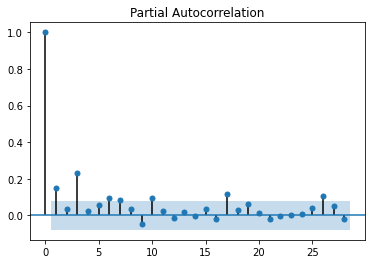

In [32]:
# PACF plot of time series: if tapers to O => MA model

from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(patient.TEMP)
plt.show()

In [30]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(patient.TEMP) # data is not stationairy

(0.01, False)

#### Grid search hyperparameters

In [25]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
    #test.reset_index(drop=True,inplace = True)
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [26]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [14]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values) #patient.TEMP.values etc

NameError: name 'series' is not defined

#### Fill in hyperparameters, fit ARIMA model and plot residual errors

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  491
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -195.000
Method:                       css-mle   S.D. of innovations              0.359
Date:                Tue, 12 Jan 2021   AIC                            404.001
Time:                        08:55:38   BIC                            433.376
Sample:                             1   HQIC                           415.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.004     -0.066      0.947      -0.009       0.008
ar.L1.D.y     -0.8951      0.044    -20.319      0.000      -0.981      -0.809
ar.L2.D.y     -0.8626      0.058    -14.983      0.0

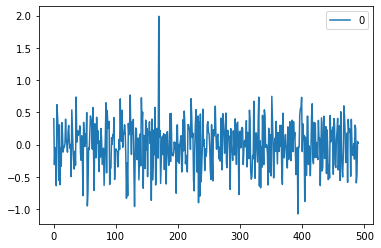

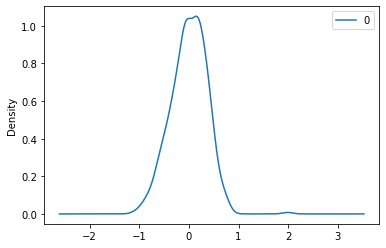

                0
count  491.000000
mean    -0.000149
std      0.360192
min     -1.076657
25%     -0.225201
50%      0.015499
75%      0.248586
max      1.990510


In [24]:
# split into train and test sets
X = patient.TEMP.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# fit model
model = ARIMA(train, order=(5,1,0)) # fill in the p, d , q values from grid search
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid) 
residuals.plot()
plt.show()
# density plot of residuals 
residuals.plot(kind='kde') 
plt.show()
# summary stats of residuals: mean close to zero , and st dev close to 1
print(residuals.describe())

#### Evaluate an ARIMA model using a walk-forward validation

predicted=36.507204, expected=36.500000
predicted=36.590140, expected=36.500000
predicted=36.394827, expected=36.500000
predicted=36.478077, expected=36.700000
predicted=36.584419, expected=36.600000
predicted=36.516376, expected=36.800000
predicted=36.603572, expected=36.700000
predicted=36.597324, expected=37.200000
predicted=36.730519, expected=37.300000
predicted=36.787828, expected=36.900000
predicted=36.912445, expected=37.400000
predicted=37.096488, expected=37.300000
predicted=37.031725, expected=37.500000
predicted=37.280511, expected=36.400000
predicted=37.173412, expected=36.300000
predicted=37.152284, expected=36.800000
predicted=36.942604, expected=37.100000
predicted=36.807754, expected=37.200000
predicted=36.874458, expected=37.200000
predicted=36.813813, expected=36.500000
predicted=36.849077, expected=37.000000
predicted=37.053671, expected=36.100000
predicted=36.801533, expected=37.000000
predicted=36.959737, expected=36.600000
predicted=36.629880, expected=36.800000


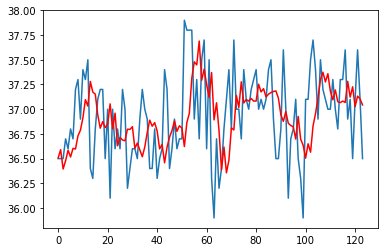

In [23]:
# split into train and test sets
X = patient.TEMP.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0)) # fill in p, d, q values from grid search
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()